In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from config import pickle_file
from tqdm import tqdm
import nltk
import collections
import numpy as np
import os
import librosa

In [35]:
with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

In [36]:
keys = data.keys()
# 打印键列表
for key in keys:
    print(key)

VOCAB
IVOCAB
train
dev
test


In [37]:
print('训练集:'+str(len(data['train'])))
print('dev:'+str(len(data['dev'])))
print('test:'+str(len(data['test'])))
print('vocab_size:' + str(len(data['VOCAB'])))

训练集:120098
dev:14326
test:7176
vocab_size:4335


In [40]:
char_list = data['IVOCAB']
vocab_size = len(char_list)
samples = data['train']
bigram_counter = collections.Counter()

for sample in tqdm(samples):
    text = sample['trn']
    # text = [char_list[idx] for idx in text]
    tokens = list(text)
    bigrm = nltk.bigrams(tokens)
    bigram_counter.update(bigrm)
print(bigram_counter.most_common(10))

100%|██████████| 120098/120098 [00:01<00:00, 115708.96it/s]

[((24, 298), 4302), ((5, 146), 3791), ((147, 366), 3562), ((275, 356), 2870), ((356, 68), 2790), ((365, 70), 2729), ((365, 142), 2591), ((451, 183), 2547), ((65, 5), 2439), ((293, 133), 2376)]
<built-in method keys of Counter object at 0x00000248A10D7630>


In [46]:
print(char_list[24],char_list[298])
print(char_list[5],char_list[146])
print(char_list[147],char_list[366])

中 国
市 场
公 司


In [48]:
temp_dict = dict()
for key, value in bigram_counter.items():
    temp_dict[key] = value

print('smoothing and freq -> prob')
bigram_freq = dict()
# 整个的字符表
for i in tqdm(range(vocab_size)):
    freq_list = []
    for j in range(vocab_size):
        if (i, j) in temp_dict:
            freq_list.append(temp_dict[(i, j)])
        else:
            # 保证每个字符对至少一次
            freq_list.append(1)

    freq_list = np.array(freq_list)
    freq_list = freq_list / np.sum(freq_list)

    assert (len(freq_list) == vocab_size)
    bigram_freq[i] = freq_list

print(len(bigram_freq[0]))
# with open('bigram_freq.pkl', 'wb') as file:
#     pickle.dump(bigram_freq, file)

smoothing and freq -> prob


100%|██████████| 4335/4335 [00:06<00:00, 683.57it/s]


4335


In [70]:
print(char_list[1])

<eos>


In [71]:
print(bigram_freq[1][1])

0.0002306805074971165


In [ ]:
max_input_len = float('-inf')
max_target_len = float('-inf')

In [2]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [3]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

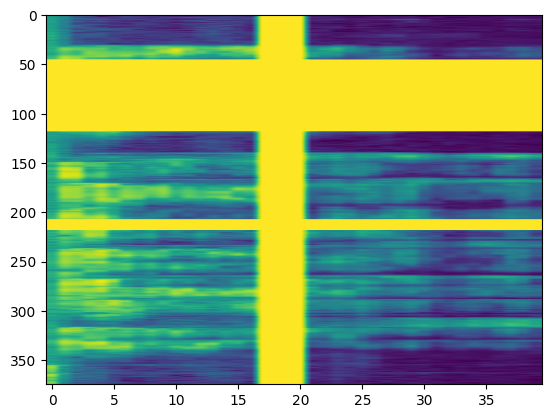

In [4]:
plt.figure()
plt.imshow(spec_augment(x),aspect= 'auto')
plt.show()